# Análisis de datos Citi Bike System NYC

## Introducción

El sistema de uso compartido de bicicletas en la ciudad de Nueva York (EE.UU.) publica diariamente gran cantidad de datos de actividad sobre su uso.

Estos datos han dado lugar, como no, a algunos [análisis sobre la evolución de este servicio y posibles factores que puedan influenciar su uso](http://toddwschneider.com/posts/a-tale-of-twenty-two-million-citi-bikes-analyzing-the-nyc-bike-share-system/). En esta práctica vamos a proponer el análisis de datos resumen diarios sobre la utilización de este servicio entre julio de 2013 y noviembre de 2015.

La filosofía de esta práctica es fomentar que consultéis la documentación en línea tanto de Pandas como de Seaborn, para así familiarizaros más con los diferentes métodos disponibles para resolver los ejercicios propuestos. En cada pregunta, se ofrecen consejos sobre partes relevantes de esta documentación relacionadas con las tareas que se piden.

## Descripción de los datos

El archivo de datos que vamos a utilizar puede obtenerse de [esta url](https://raw.githubusercontent.com/toddwschneider/nyc-citibike-data/master/data/daily_citi_bike_trip_counts_and_weather.csv). Se trata de un fichero en formato CSV, que se ha creado mezclando [datos del City Bike System](https://www.citibikenyc.com/system-data) con [datos de la National Oceanic and Atmospheric Administration (NOAA)](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094728/detail), sobre NYC. El fichero cuenta con las siguientes columnas:

* *date*: fecha del dato, en formato YYYY-MM-DD.
* *trips*: entero positivo, número total de viajes acumulados ese día.
* *precipitation*: entero positivo, cantidad de lluvia total registrada ese día (pulgadas).
* *snow_depth*: entero positivo, altura de nieve (pulgadas).
* *snowfall*: entero positivo, registro de precipitación en forma de nieve (pulgadas).
* *max_temperature*: entero, temperatura máxima registrada (ºF).
* *min_temperature*: entero, temperatura mínima registrada (ºF).
* *average_wind_speed*: entero, velocidad promedio del viento (MPH, millas por hora).
* *dow*: [0, 7]; código de día de la semana, 0 corresponde al domingo.
* *year*: Año del registro.
* *month*: Mes del registro.
* *holiday*: Valor lógico, indica si esa fecha es festivo (TRUE) o no (FALSE).
* *stations_in_service*: Número de estaciones para tomar o dejar bicicletas que estaban en servicio ese día.
* *weekday*: Valor lógico, indica si esa fecha corresponde a un día entre semana (de lunes a viernes, ambos inclusive).
* *weekday_non_holiday*: Valor lógico, indica si la fecha corresponde a un día entre semana festivo.

Los datos están tomados con frecuencia diaria (filas del archivo).

In [2]:
%matplotlib inline

# Importamos las bibliotecas que vamos a usar
import numpy as np
import pandas as pd
import seaborn as sns

## Ejercicio 1
#### Valor: 25 puntos

Representa mediante Pandas y Seaborn una serie temporal que muestre la evolución del número total de viajes en Citi Bike cada día, y luego por semanas. ¿Se puede observar algún patrón cíclico en esta serie de valores?

**Consejo**: La documentación de la función [`pandas.read_csv(...)`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) indica cómo interpretar directamente el índice temporal de los datos de las series a partir de una de las columnas de los datos. Así, el índice se usa en todas las demás columnas del `DataFrame` de Pandas. No obstante, también se puede resolver el ejercicio creando objetos Pandas de tipo `Series`, a partir de las columnas del `DataFrame` inicial.

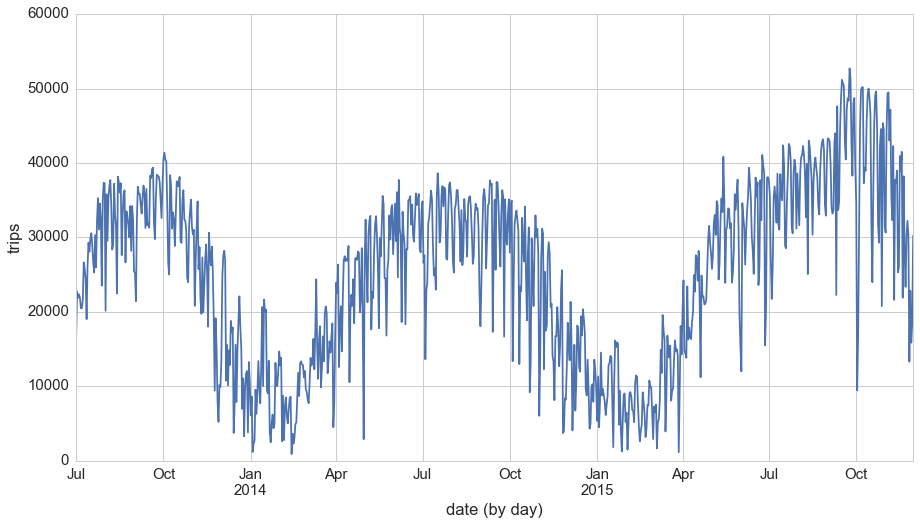

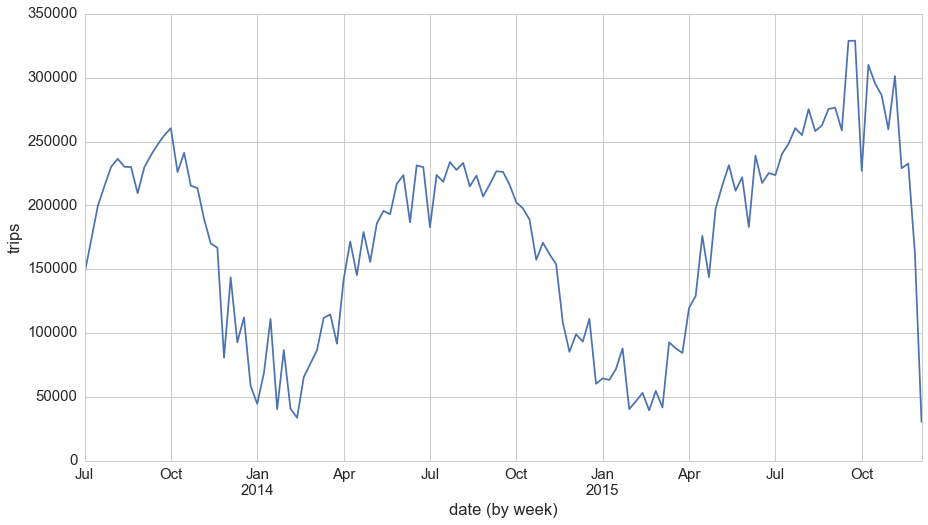

In [4]:
# Leemos los datos del archivo csv
bikes_df = pd.read_csv('./daily_citi_bike_trip_counts_and_weather.csv', 
                       sep=',',
                       parse_dates=[0],
                       infer_datetime_format=True
                      )

# Serie temporal de viajes por día
daily_series = pd.Series(data=np.array(bikes_df['trips']), name='trips', index=bikes_df['date'])

# Serie temporal de viajes por semana
weekly_series = daily_series.resample('w').sum()

sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')

# Realización de los diagramas de las dos series temporales
daily_series.plot(figsize=(15, 8)).set(xlabel='date (by day)', ylabel='trips')
sns.plt.show()

weekly_series.plot(figsize=(15, 8)).set(xlabel='date (by week)', ylabel='trips')
sns.plt.show()

En los meses de primavera y verano es cuando se producen más viajes en bicicleta, lo que nos podría llevar a pensar que la climatología influye de alguna manera en el número de viajes que se realizan diariamente.

Para realizar el ejercicio he hecho uso de la función *resample* (http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html).

## Ejercicio 2
#### Valor: 30 puntos

Genera un scatterplot que represente el número diario de viajes respecto a la temperatura máxima registrada ese día. ¿Se puede observar alguna correlación entre ambas variables?

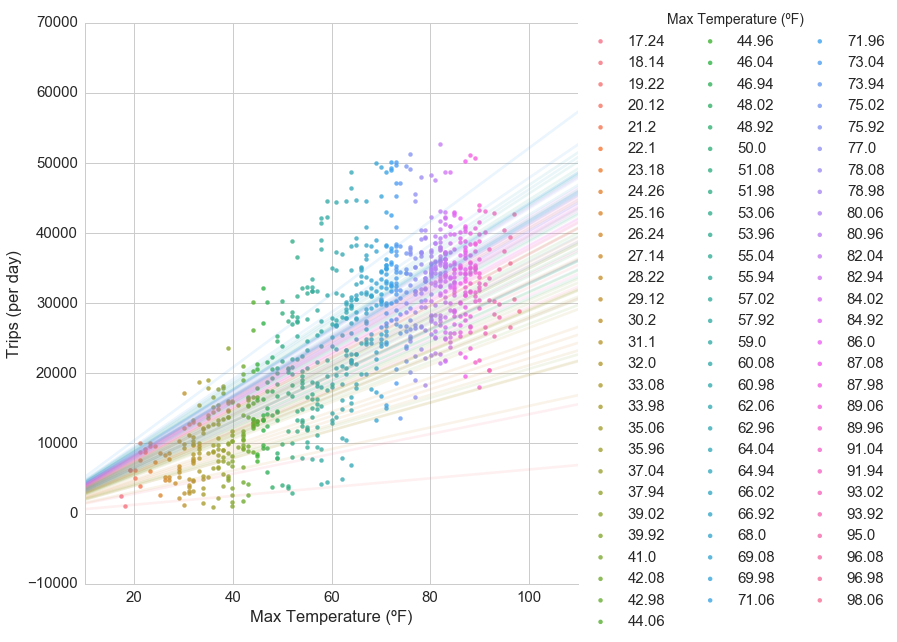

In [10]:
(sns.lmplot(x='max_temperature', 
            y='trips', 
            data=bikes_df, 
            hue='max_temperature', 
            line_kws={'alpha': 0.10}, 
            fit_reg=True,
            legend_out=True, 
            legend=None,
            ci=None,
            size=9)
 .add_legend(ncol=3, title='Max Temperature (ºF)')
 .set(xlabel='Max Temperature (ºF)', ylabel='Trips (per day)')
)
sns.plt.show()

La relación entre la temperatura máxima y el número de viajes es, que cuanto mayor es la temperatura máxima, mayor número de viajes hay. 

Representa ahora las dos series de valores (viajes diarios y número de estaciones disponibles) conjuntamente en la misma gráfica, con dos subfiguras en vertical dentro de la misma figura.. ¿Podemos extraer alguna conclusión adicional sobre la relación entre ambas variables? Calcula la correlación entre ambas series usando una [ventana temporal deslizante de 90 días](http://pandas.pydata.org/pandas-docs/stable/computation.html#window-functions). ¿Varían de alguna forma nuestras conclusiones?

**Consejo**: Revisa la documentación sobre la función [`pd.Series.rolling(...)`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html), junto con los siguientes enlaces antes de resolver el ejercicio:
1. https://svds.com/avoiding-common-mistakes-with-time-series/
2. https://blog.oraylis.de/2016/03/a-common-pitfall-with-correlations-in-timeseries/

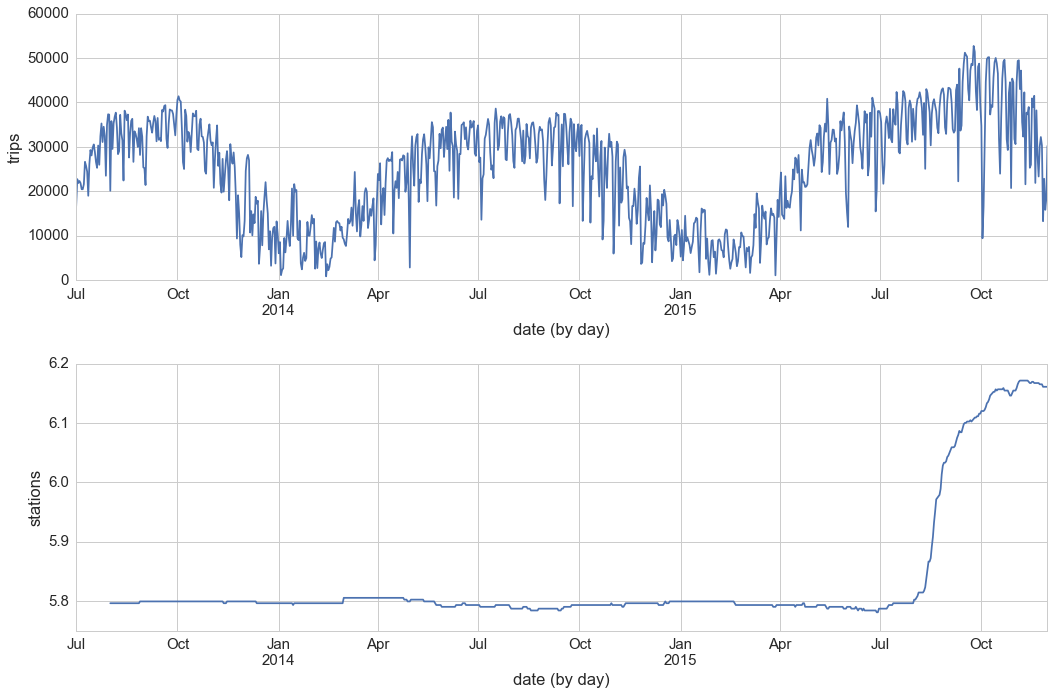

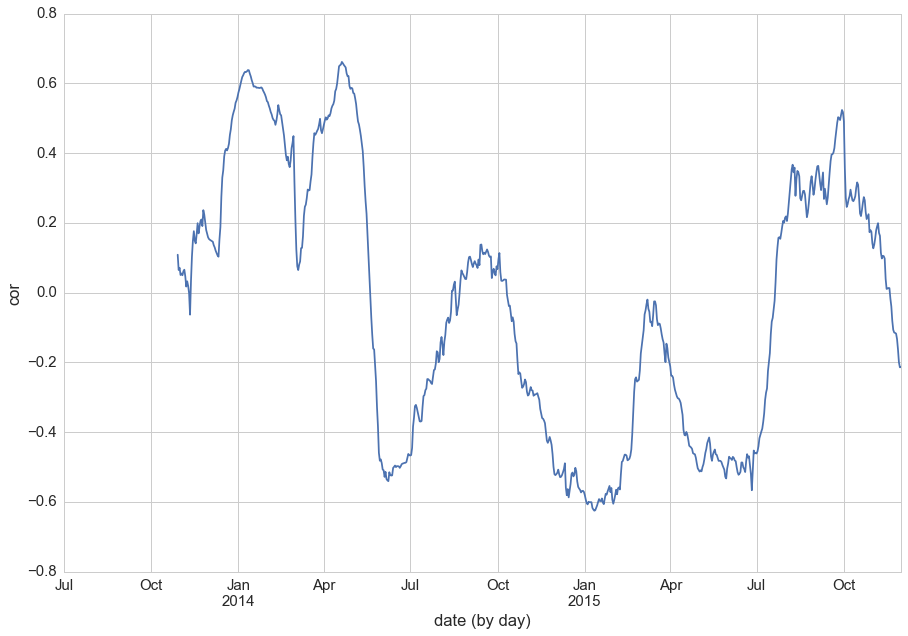

In [30]:
stations_daily_series = pd.Series(data=np.array(bikes_df['stations_in_service']), 
                                  name='stations', 
                                  index=bikes_df['date'])

sns.plt.figure(1)

sns.plt.subplot(211)
(daily_series.plot(figsize=(15, 10)).set(xlabel='date (by day)', ylabel='trips'))

sns.plt.subplot(212)
(np.log(stations_daily_series).plot(figsize=(15, 10)).set(xlabel='date (by day)', ylabel='stations'))

sns.plt.tight_layout()
sns.plt.show()

(daily_series.rolling(window = 90)
 .corr(stations_daily_series)
 .plot(figsize=(15, 10))
 .set(xlabel='date (by day)', ylabel='cor'))
sns.plt.show()


El aumento de estaciones disponibles en agosto y septiembre de 2015 se produce por la creación de nuevas estaciones (http://www.citigroup.com/citi/news/2015/150806a.htm) y la expansión del servicio en New Jersey (http://www.nytimes.com/2015/09/21/nyregion/bike-sharing-programs-gain-a-toehold-in-new-jersey.html?_r=2).

Vamos a mostrar otra gráfica con los períodos de julio de 2013 hasta agosto de 2015 para estudiar mejor este tramo de tiempo, ya que es difícil apreciar el incremento o decremento de estaciones disponibles aunque se aplique una transformación logarítmica sobre los datos.

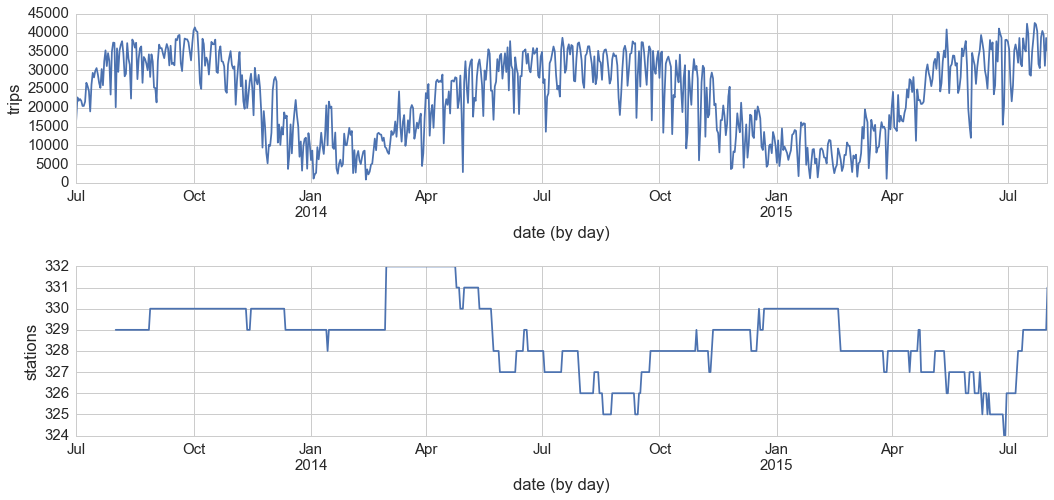

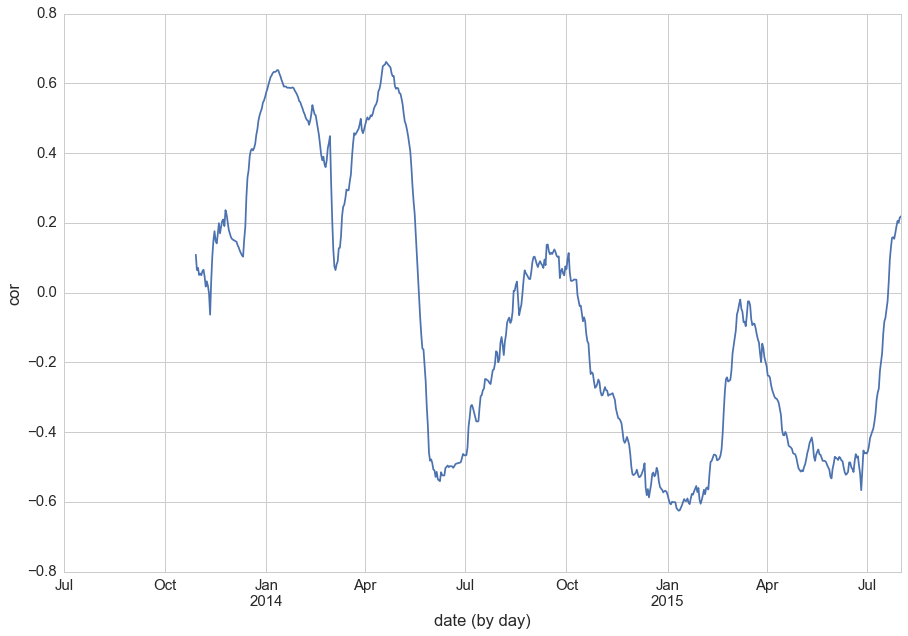

In [200]:
sns.plt.figure(2)

sns.plt.subplot(311)
(daily_series.ix['2013-07-01':'2015-08-01']
 .plot(figsize=(15, 10))
 .set(xlabel='date (by day)', 
      ylabel='trips'))

sns.plt.subplot(312)
(stations_daily_series.ix['2013-07-01':'2015-08-01']
 .plot(figsize=(15, 10))
 .set(xlabel='date (by day)', 
      ylabel='stations'))

sns.plt.tight_layout()
sns.plt.show()

(daily_series.ix['2013-07-01':'2015-08-01'].rolling(window = 90)
 .corr(stations_daily_series.ix['2013-07-01':'2015-08-01'])
 .plot(figsize=(15, 10))
 .set(xlabel='date (by day)', ylabel='cor'))
sns.plt.show()

No es posible observar una relación entre el número de estaciones disponibles y el número de viajes de manera clara en la primera figura.

Sin embargo, al mostrar la gráfica de las correlaciones usando una ventana temporal de 90 días (una herramienta importante al trabajar con series temporales para no llegar a conclusiones equivocadas) se aprecia que, a lo largo del tiempo, hay una correlación importante entre ambas variables. 
Desafortunadamente, esta correlación cambia a lo largo del tiempo de manera pronunciada alcanzando picos negativos y positivos.

Es posible que el número de estaciones disponibles baje cuando la demanda es mayor, ya que existen problemas de balanceo de bicicletas (llevar bicicletas de zonas que tienen bicicletas a estaciones que no tienen).

http://grist.org/cities/why-is-new-yorks-citi-bike-losing-tons-of-money/

http://www.nytimes.com/2014/03/27/nyregion/as-citi-bike-approaches-anniversary-worries-abound.html

http://www.citylab.com/commute/2014/08/balancing-bike-share-stations-has-become-a-serious-scientific-endeavor/379188/

http://www.businessinsider.com/where-citi-bike-stations-are-often-empty-2013-8

http://nypost.com/2015/01/12/big-drop-in-citibike-use-during-2014/

En los últimos cuatro meses del año 2015, con la apertura de nuevas estaciones, este problema aparentemente se soluciona, de tal manera que se consigue un nuevo pico en el número de viajes diarios, llegando a superar los 50.000.

## Ejercicio 3
#### Valor: 20 puntos

Escoja un diagrama adecuado para representar la diferencia de valores entre el número total de viajes registrados en los días laborables y los registrados en días no laborables (fines de semana y festivos entre semana). ¿A qué conclusiones podemos llegar?

**Consejo**: Revisa la documentación de Seaborn sobre [representación gráfica con datos categóricos](http://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial) para resolver el ejercicio.

         Median 
holiday
False    30213.0
True     23368.5
Name: trips, dtype: float64


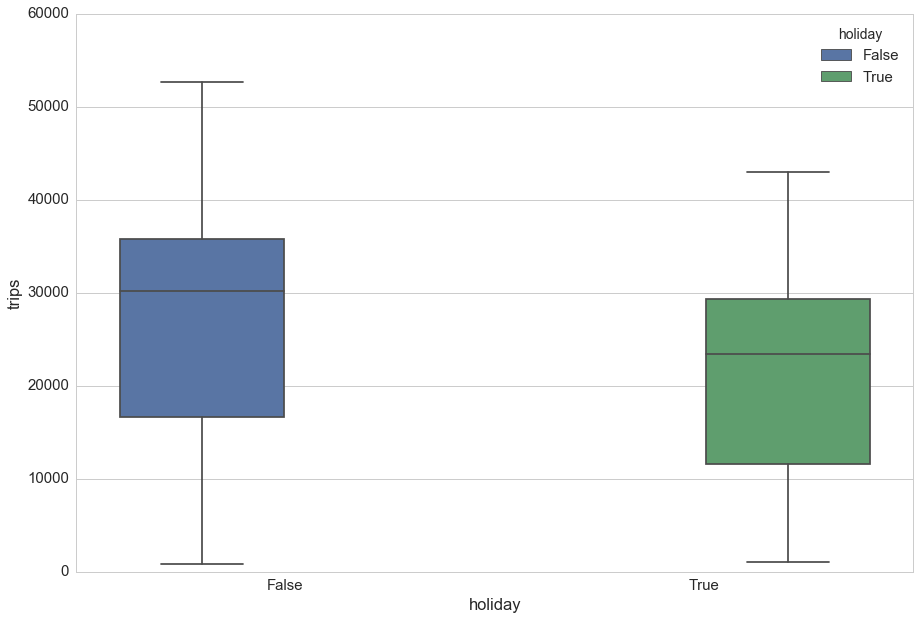

In [23]:
bikes_df_holidays = bikes_df[['trips', 'holiday', 'month', 'dow']]
pd.options.mode.chained_assignment = None 
bikes_df_holidays.loc[ (bikes_df_holidays.dow == 0) | (bikes_df_holidays.dow == 6), 'holiday'] = True

#sns.plt.figure(figsize=(15, 10))
#sns.swarmplot(x='holiday', y='trips', hue='month', size=8, data=bikes_df_holidays)
#sns.plt.show()

print('         Median \n' + str(bikes_df_holidays.groupby('holiday').trips.median()))

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x='holiday', y='trips', hue='holiday', data=bikes_df_holidays)
sns.plt.show()

Con este gráfico podemos observar que la mayoría de viajes se producen en días que no son vacaciones.

Se podría pensar que son los días festivos (fines de semana y días festivos) cuando la gente aprovecha para realizar viajes en bicicleta, pero esto no es así. La mediana de viajes en días no festivos fue ligeramente superior a 30.000 y en días festivos fue entorno a los 23.300.

No hay que perder de vista que hay más registros de días que no son vacaciones (alrededor de 600 días que no son vacaciones frente alrededor de 275) como se aprecia en el siguiente gráfico.


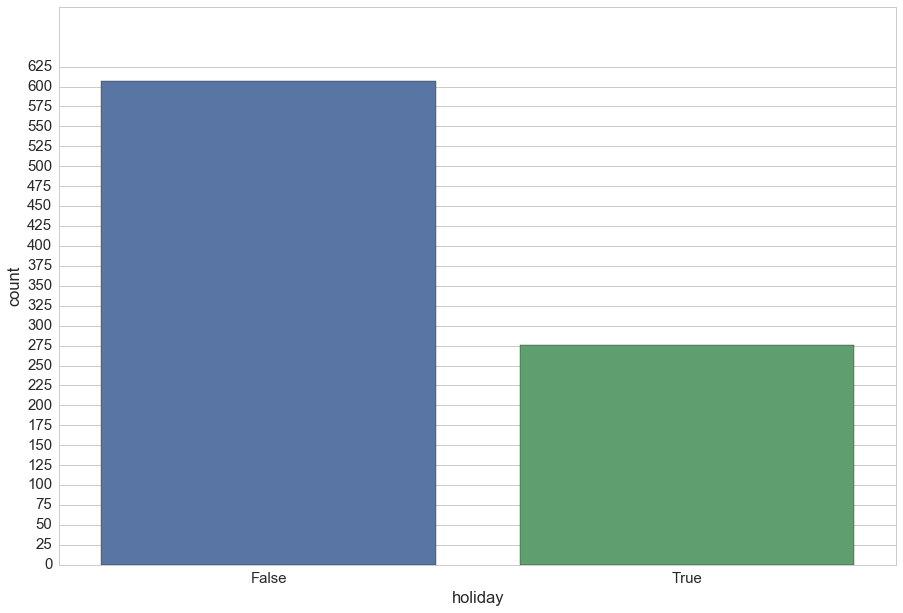

In [83]:
sns.plt.figure(figsize=(15, 10))
sns.countplot(x='holiday', data=bikes_df_holidays).set(yticks=np.arange(0, 626, 25))
sns.plt.show()

En el siguiente gráfico se puede ver cómo la tendencia del número de viajes diarios por mes no es el mismo en los días festivos (incluidos fines de semana) y días no festivos, ya que en los meses junio, septiembre y octubre, mientras que el número de viajes diarios en días de trabajo crece, en los días festivos decrece. 

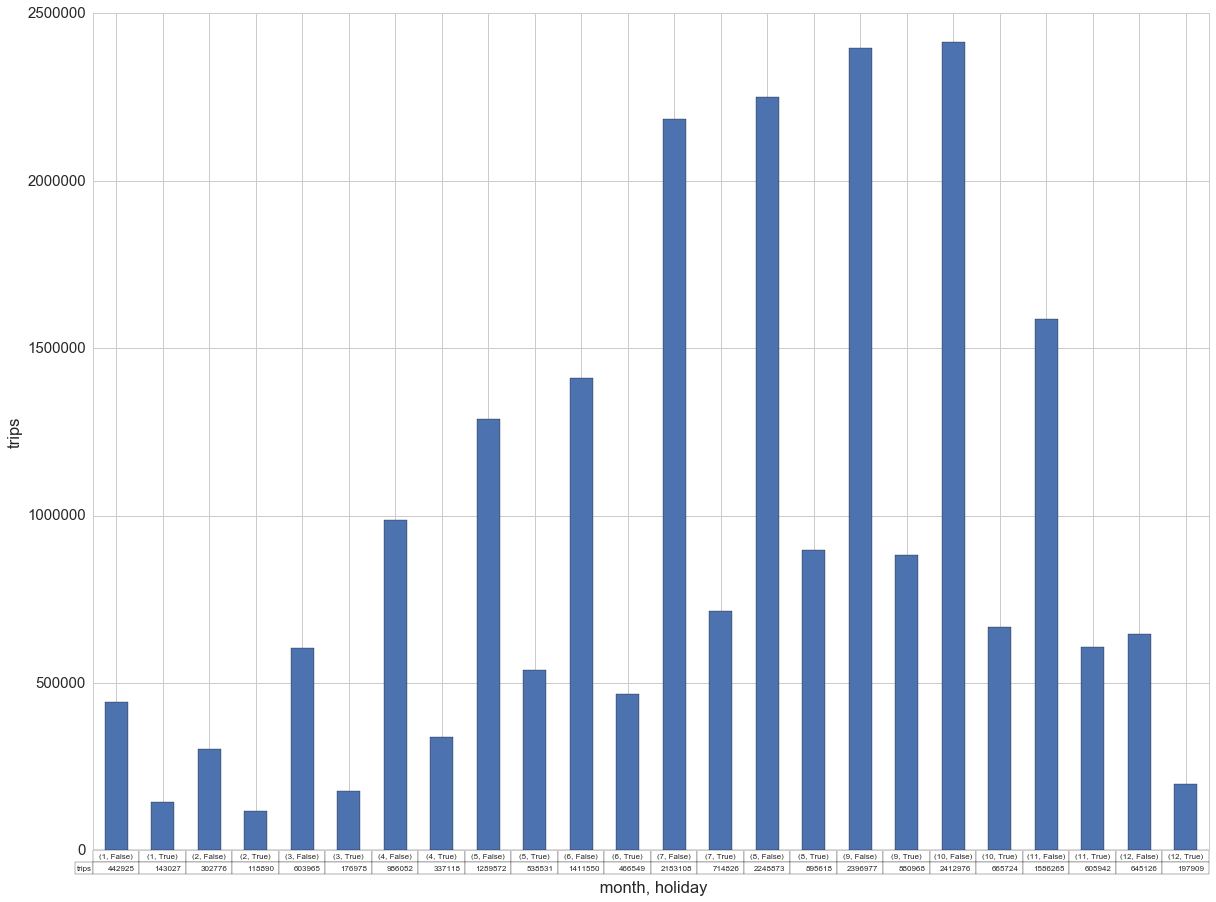

In [25]:
months_and_holiday = bikes_df_holidays.groupby(['month', 'holiday']).trips.sum()
(months_and_holiday.plot(kind='bar', table=True, figsize=[20, 15])
 .set(xlabel='\n month, holiday', ylabel='trips', xticklabels=[]))
sns.plt.show()

In [27]:
import calendar

i = 0
mh_list = list(months_and_holiday.iteritems())
for cat, val in mh_list:
    if i < len(mh_list) - 1:
        month = cat[0]
        if month == mh_list[i + 1][0][0]:
            month = calendar.month_name[cat[0]]
            no_holiday = val
            holiday = mh_list[i + 1][1]
            total = holiday + no_holiday
            prct_holiday = (holiday*100)/total
            prct_no_holiday = (no_holiday*100)/total
            print('Month: %s, Holiday: %f%%, No Holiday: %f%%' % (month, prct_holiday, prct_no_holiday))
        i += 1

Month: January, Holiday: 24.409337%, No Holiday: 75.590663%
Month: February, Holiday: 28.195301%, No Holiday: 71.804699%
Month: March, Holiday: 22.662089%, No Holiday: 77.337911%
Month: April, Holiday: 25.478056%, No Holiday: 74.521944%
Month: May, Holiday: 29.458460%, No Holiday: 70.541540%
Month: June, Holiday: 24.841555%, No Holiday: 75.158445%
Month: July, Holiday: 24.666745%, No Holiday: 75.333255%
Month: August, Holiday: 28.482130%, No Holiday: 71.517870%
Month: September, Holiday: 26.875619%, No Holiday: 73.124381%
Month: October, Holiday: 21.623542%, No Holiday: 78.376458%
Month: November, Holiday: 27.640729%, No Holiday: 72.359271%
Month: December, Holiday: 23.475775%, No Holiday: 76.524225%


Si comparamos para cada mes lo que suponen los viajes en días de diario y los viajes en días festivos, se observa que los viajes en días festivos nunca llegan a suponer al menos el 50% de los viajes de cada mes, si bien la proporción que representan no es despreciable.

Quizás el hecho de que sea festivo no es tan determinante para las personas para realizar viajes en bicicleta como sí lo pudieran ser otras.

In [237]:
bikes_df.corr()['trips'].sort_values(ascending=False)

trips                  1.000000
max_temperature        0.782832
min_temperature        0.761090
month                  0.424335
stations_in_service    0.391971
weekday_non_holiday    0.250608
weekday                0.198591
year                   0.040581
dow                    0.010768
holiday               -0.162868
precipitation         -0.265424
snowfall              -0.275754
snow_depth            -0.482982
average_wind_speed    -0.496404
Name: trips, dtype: float64

Apoyándonos en la primera gráfica de este ejercicio y en las correlaciones de la variable *trips* para el resto de variables, podríamos decir que la temperatura máxima es la que mayor impacto tiene a la hora de subir o bajar el número de viajes diarios.

## Ejercicio 4
#### Valor: 25 puntos

Usando toda la serie de valores que tenemos disponible, ¿cuál es el día de la semana en que realizan en total más viajes en Citi Bike? ¿Y el que menos? ¿Hay diferencias si desglosamos este gráfico por años?

**Consejo**: Analiza cómo podemos representar gráficos en los que los paneles o ejes tengan en cuenta valores de nuestras variables en el tutorial [*Plotting on data-aware grids*](http://seaborn.pydata.org/tutorial/axis_grids.html) de la documentación de Seaborn.

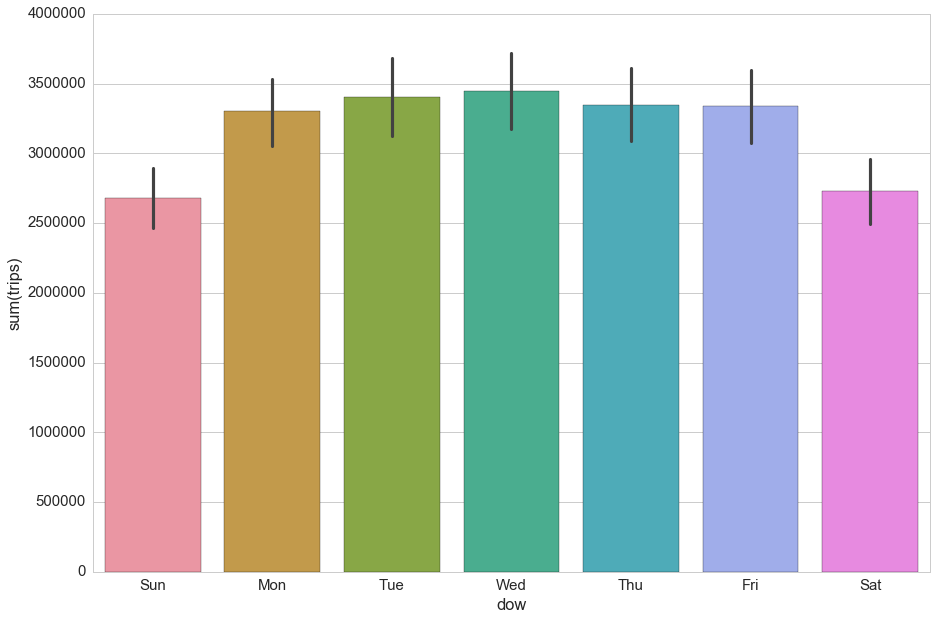

In [139]:
#Ordenamos la lista de días de la semana:
weekday_nums = np.sort(bikes_df['dow'].unique(), kind='mergesort')  
#Lista de días de la semana por abreviatura empezando por el domingo:
week_days = np.roll(list(calendar.day_abbr), 1)

#DataFrame con sólo las columnas que nos interesan:
bikes_df_year_dow = bikes_df[['trips','dow','year']]
#Desabilitado warning:
pd.options.mode.chained_assignment = None 
#dow ahora serán las abreviaturas de los días de la semana en lugar de los números:
bikes_df_year_dow['dow'] = bikes_df_year_dow.dow.replace(weekday_nums, week_days)

# Viajes por día de la semana 

sns.plt.figure(figsize=(15, 10))
sns.barplot(x='dow', y='trips', data=bikes_df_year_dow, estimator=sum, order=week_days)
sns.plt.show()

El día de la semana en el que se realizan más viajes es el jueves (Thursday) y el que menos el lunes (Monday).

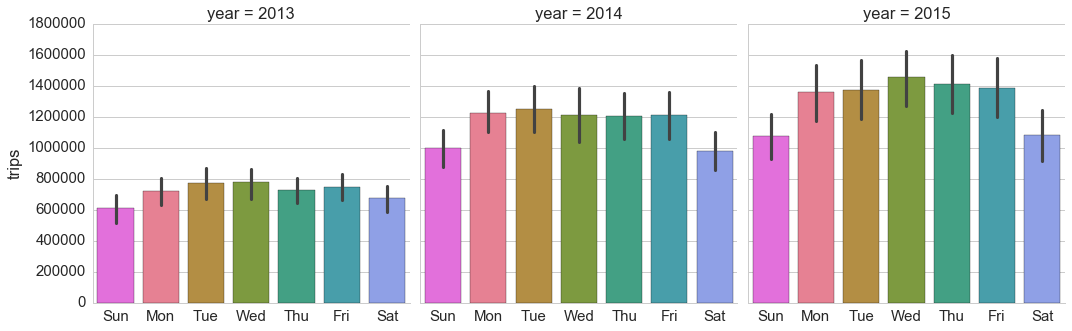

In [141]:
# Viajes por día de la semana desglosado por año

sns.plt.figure(figsize=(15, 10))
grid = sns.FacetGrid(bikes_df_year_dow, col='year', size=5, hue='dow')
(grid.map(sns.barplot, 'dow', 'trips', order=week_days, estimator=sum)
 .set(xlabel='')
)
sns.plt.show(grid)

Si en el anterior gráfico podíamos determinar qué días de la semana tenían más y menos viajes a lo largo de todo el período, aquí podemos ver que esos días en los que hay más viajes (o menos) no son los mismos en cada año. 

Hay que tener en cuenta que en el año 2013 sólo se tienen datos a partir de julio y del año 2015 sólo se tienen datos hasta el mes de noviembre incluido.

## Conclusiones y comentarios

Para la realización de esta práctica se ha usado Jupyter Notebooks e IPython Notebook. Se ha utilizado la herramienta de control de versiones Git y el repositorio de este proyecto está en la siguiente URL https://github.com/jvicentem/pandas-and-seaborn-assignment.

Esta práctica me ha parecido muy interesante para asegurar y explorar más la creación de gráficos con Seaborn y Matplotlib, además de usar algunas estructuras y funciones que ofrece Pandas y la librería Numpy. 

Me ha gustado mucho el contexto de la práctica: trabajar con datos reales e intentar obtener conocimiento a partir de ellos. 

En algunos momentos me he sentido un poco limitado a la hora de trabajar con los datos: no he sabido muy bien cómo interpretar los gráficos u operaciones realizadas y llegar a conclusiones firmes. En muchas ocasiones he dudado sobre las conclusiones a las que llego porque he intentado hacer diferentes operaciones y gráficos para enfocar posibles respuestas a preguntas de distintas maneras.